<a href="https://colab.research.google.com/github/ary3120-droid/myproject/blob/main/1_21olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

연결


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


라이브러리 설치

In [3]:
!pip install koreanize-matplotlib -q


라이브러리 임포트

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib  # 한글 폰트 자동 설정


경로 설정 및 데이터 로드

In [5]:
BASE_PATH = '/content/drive/MyDrive/olist/'

# 날짜 컬럼
date_cols = ['order_purchase_timestamp']

orders = pd.read_csv(
    os.path.join(BASE_PATH, 'olist_orders_dataset.csv'),
    parse_dates=date_cols
)

items = pd.read_csv(os.path.join(BASE_PATH, 'olist_order_items_dataset.csv'))
products = pd.read_csv(os.path.join(BASE_PATH, 'olist_products_dataset.csv'))
translation = pd.read_csv(os.path.join(BASE_PATH, 'product_category_name_translation.csv'))


매출 분석용 테이블 생성

In [6]:
df_revenue = (
    orders
    .merge(items, on='order_id', how='inner')
    .merge(products, on='product_id', how='inner')
    .merge(translation, on='product_category_name', how='left')
)

# 완료 주문만 필터링 (매출 신뢰성)
df_revenue = df_revenue[df_revenue['order_status'] == 'delivered'].copy()

# 영문 카테고리명 정리
df_revenue['category_name'] = (
    df_revenue['product_category_name_english']
    .fillna(df_revenue['product_category_name'])
)


시각화 함수

In [7]:
def plot_revenue_analysis(data):
    sns.set(style="whitegrid")

    # 1️⃣ 카테고리별 매출 TOP 10
    plt.figure(figsize=(12, 6))
    top_10 = (
        data
        .groupby('category_name')['price']
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )

    sns.barplot(
        x=top_10.values,
        y=top_10.index
    )

    plt.title('수익 기여도 상위 10개 카테고리', fontsize=15)
    plt.xlabel('총 매출 (BRL)')
    plt.ylabel('카테고리')
    plt.tight_layout()
    plt.show()

    # 2️⃣ 월별 매출 트렌드
    data = data.copy()
    data['order_month'] = data['order_purchase_timestamp'].dt.to_period('M').astype(str)

    monthly_rev = (
        data
        .groupby('order_month')['price']
        .sum()
    )

    plt.figure(figsize=(14, 6))
    monthly_rev.plot(marker='o', linewidth=2)
    plt.title('월별 총 매출 추이 (완료 주문 기준)', fontsize=15)
    plt.ylabel('매출 (BRL)')
    plt.xlabel('월')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


실행 + 검증 출력

/tmp/ipython-input-1923106116.py:22: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:22: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:22: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:22: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:22: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:22: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:22: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/t

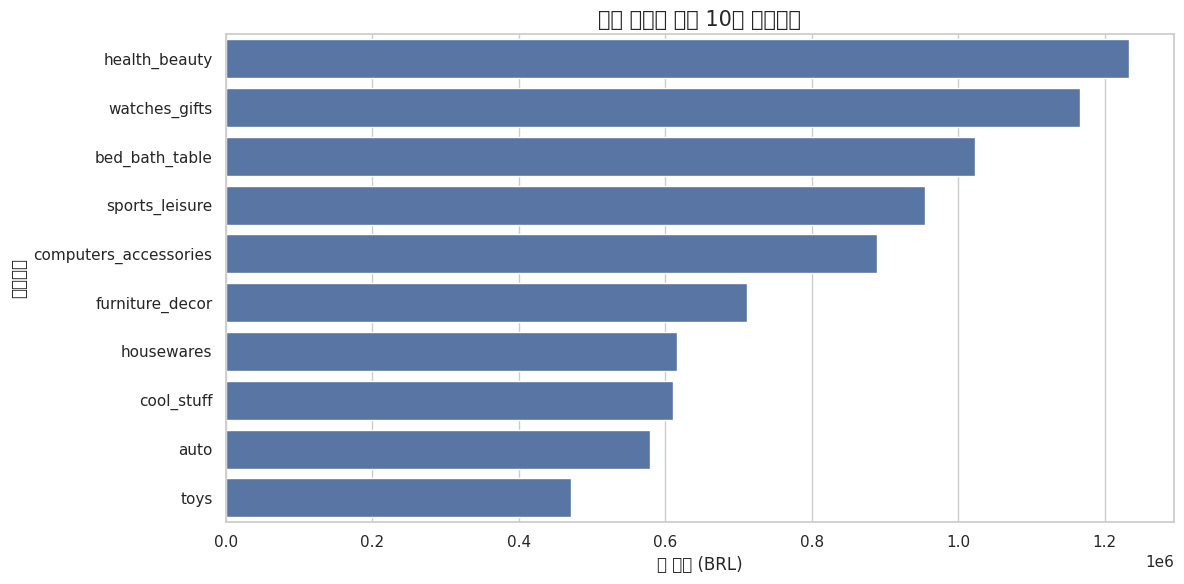

/tmp/ipython-input-1923106116.py:42: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:42: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:42: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:42: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:42: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:42: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1923106116.py:42: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

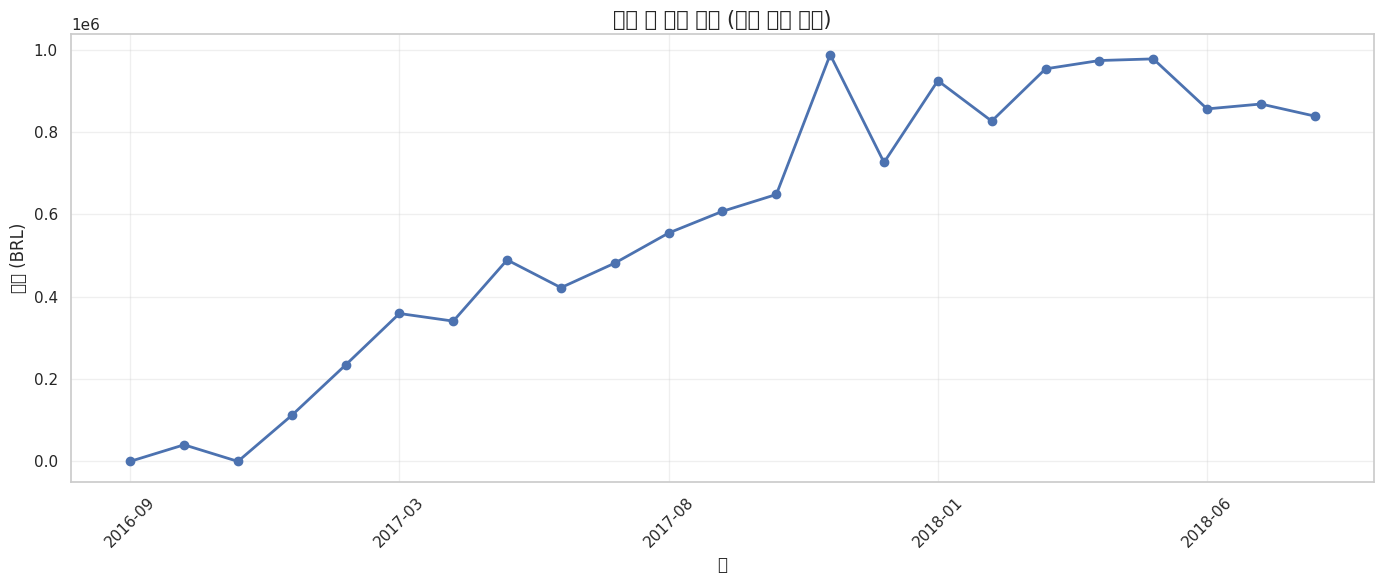

분석 완료! 총 상품 판매 건수: 110,197건
총 주문 수: 96,478건


In [8]:
plot_revenue_analysis(df_revenue)

print(f"분석 완료! 총 상품 판매 건수: {len(df_revenue):,}건")
print(f"총 주문 수: {df_revenue['order_id'].nunique():,}건")
